## **Деревья решений и ансамблевые методы (Random Forest Classifier)**

Цель этой части - применить ансамблевый метод Random Forest Classifier для анализа кредитного риска, используя ранее подготовленный и предобработанный датасет.
В рамках работы необходимо:

1) обучить модель Random Forest;
2) выполнить подбор оптимальных гиперпараметров;
3) оценить качество классификации;
4) сравнить результаты с моделью логистической регрессии;
5) визуализировать важность признаков;
6) построить ROC-кривую и матрицу ошибок для итоговой модели.

Данная часть демонстрирует, как ансамблевые методы улучшают качество прогнозирования по сравнению с базовыми моделями и какие факторы наиболее существенно влияют на предсказание кредитного риска.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    roc_curve, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd

df = pd.read_csv("credit_risk_preprocessed.csv")
df.head()
print(df.shape)

(32581, 23)


In [3]:
#@title Подготовка данных
target = "loan_status"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
#@title RandomForest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

base_preds = rf.predict(X_test)
base_probs = rf.predict_proba(X_test)[:, 1]

print("Baseline RF Accuracy:", accuracy_score(y_test, base_preds))
print("Baseline RF ROC-AUC:", roc_auc_score(y_test, base_probs))

Baseline RF Accuracy: 0.9334049409237379
Baseline RF ROC-AUC: 0.9284600329326481


In [5]:
#@title Подбор гиперпараметров Random Forest
param_grid = {
    "n_estimators": [150, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Best Hyperparameters:", rf_grid.best_params_)

best_rf = rf_grid.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


**Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}**


Подбор гиперпараметров необходим для нахождения оптимальной конфигурации модели Random Forest. Этот процесс позволяет улучшить качество классификации, повысить ROC-AUC и снизить риск переобучения, поскольку базовые параметры модели не адаптированы под структуру конкретного датасета. Используя GridSearchCV, мы систематически перебираем комбинации параметров и выбираем те, которые обеспечивают максимальную предсказательную способность модели.

In [6]:
#@title Оптимизированный Random Forest
rf_preds = best_rf.predict(X_test)
rf_probs = best_rf.predict_proba(X_test)[:, 1]

print("Optimized RF Accuracy:", accuracy_score(y_test, rf_preds))
print("Optimized RF ROC-AUC:", roc_auc_score(y_test, rf_probs))
print("\nClassification Report:\n", classification_report(y_test, rf_preds))

Optimized RF Accuracy: 0.9320239373945067
Optimized RF ROC-AUC: 0.9318741382094632

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.96      0.72      0.82      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517



После подбора гиперпараметров качество модели улучшилось по ключевым метрикам.
ROC-AUC увеличился с 0.928 до 0.932, что означает более точное разделение классов.
Особенно важно, что recall для класса «дефолт» вырос до 0.72, что снижает количество пропущенных рисковых клиентов.

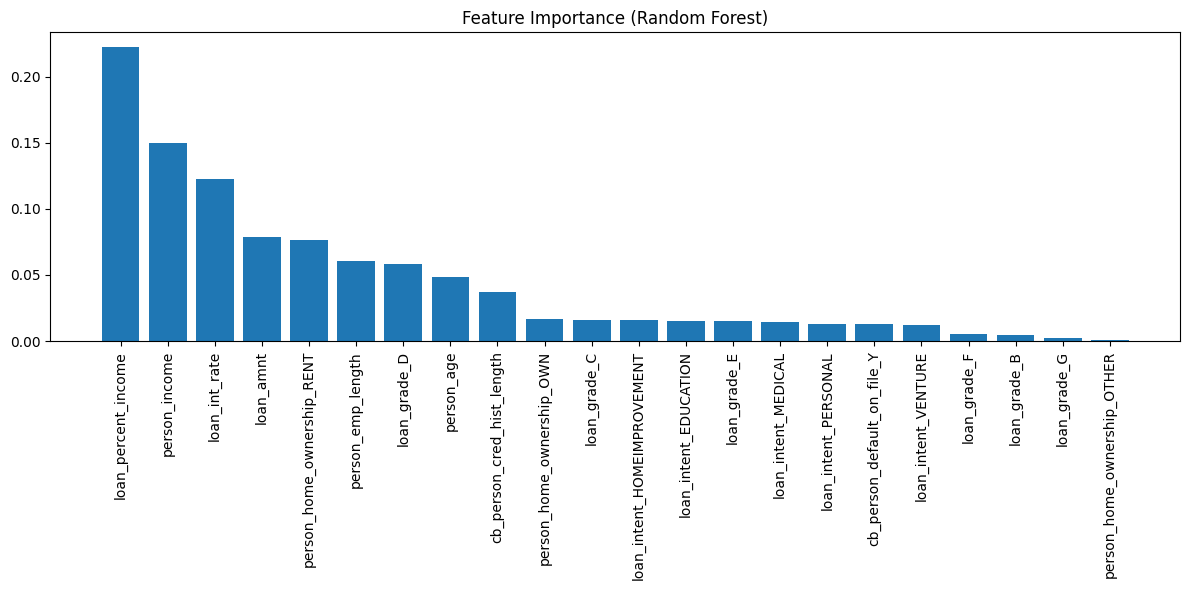

In [7]:
#@title Feature Importance (важность признаков)
import matplotlib.pyplot as plt
import numpy as np

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

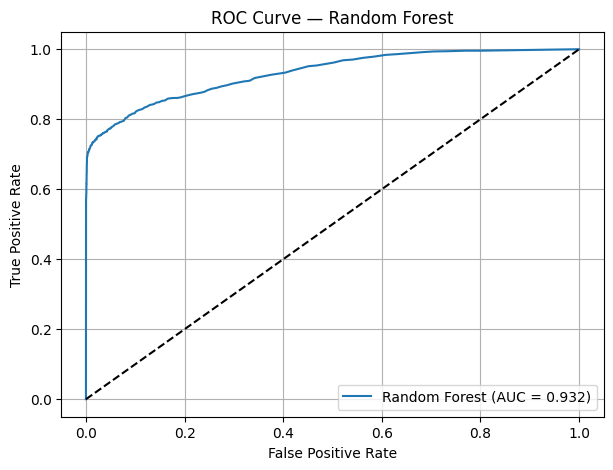

In [8]:
#@title ROC-кривая

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend()
plt.grid()
plt.show()


**модель уверенно различает дефолты и не дефолты.**

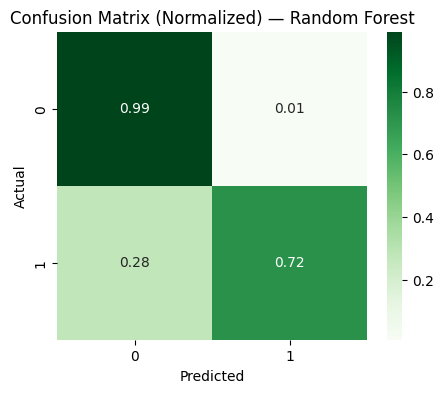

In [10]:
cm_norm = confusion_matrix(y_test, rf_preds, normalize='true')

plt.figure(figsize=(5,4))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens")
plt.title("Confusion Matrix (Normalized) — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


1) 99% не дефолтных кредитов классифицированы правильно
2) 72% дефолтов определены правильно значительно выше среднего для задач кредитного скоринга;

Модель **Random Forest** правильно выделяет ключевые экономические факторы: долговая нагрузка, доход, ставка и сумма кредита — главные предикторы дефолта. Факторы, связанные с стабильностью (стаж, жильё, кредитная история), играют второстепенную, но ощутимую роль. Это соответствует реальной логике кредитного скоринга и подтверждает корректность данных и модели.

In [11]:
import joblib

joblib.dump(best_rf, "credit_risk_rf_model.pkl")
print("Model saved!")


Model saved!
